# Two-qubit Transverse field Ising model



<img src="../logo_circular.png" width="20" height="20" />@by claudio<br>
nonlinearxwaves@gmail.com<br>


@created 30 July 2022<br>
@version 6 October 2023<br>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages 

In [2]:
from thqml import quantummap as quantummap
import tensorflow as  tf
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow_addons as tfa
np.set_printoptions(precision=2)

# Define Hamiltonian operator

$\hat{\mathcal{H}}=-J Z_0 Z_1 -h_0 Z_0 -h_1 Z_1$

In [3]:
@tf.function
def Hamiltonian(J=1, h=[0,0]):
    """ Two-qubit tranverse Ising model Hamiltonian
    
        H=-J Z0 Z1 -h0 X0 -h1 X0
        
        Params
        ------
        J = coupling shape=(1,)
        h = field shape=(2,)
    """
    out = -J*quantummap.ZZ-h[0]*quantummap.XI-h[1]*quantummap.IX
        
    return out

## Test the Hamiltonian

Hamiltonian with no field terms

In [4]:
H=Hamiltonian()
print(quantummap.Transform2Matrix(H))

tf.Tensor(
[[-1.+0.j -0.+0.j -0.+0.j -0.+0.j]
 [-0.+0.j  1.-0.j -0.+0.j -0.+0.j]
 [-0.+0.j -0.+0.j  1.-0.j -0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j -1.+0.j]], shape=(4, 4), dtype=complex64)


Hamiltonian with field terms

In [5]:
H=Hamiltonian(h=[1.1,3.2])
print(quantummap.Transform2Matrix(H))

tf.Tensor(
[[-1. +0.j -3.2+0.j -1.1+0.j -0. +0.j]
 [-3.2+0.j  1. -0.j -0. +0.j -1.1+0.j]
 [-1.1+0.j -0. +0.j  1. -0.j -3.2+0.j]
 [-0. +0.j -1.1+0.j -3.2+0.j -1. +0.j]], shape=(4, 4), dtype=complex64)


## Find eigenvalues an eigenvectors of H

Let us consider the Hamiltonian with no field

In [6]:
H=Hamiltonian()

Transforms H into a 4x4 numpy matrix

In [7]:
Hmatrix=quantummap.Transform2Matrix(H).numpy()

In [8]:
print(Hmatrix)

[[-1.+0.j -0.+0.j -0.+0.j -0.+0.j]
 [-0.+0.j  1.-0.j -0.+0.j -0.+0.j]
 [-0.+0.j -0.+0.j  1.-0.j -0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j -1.+0.j]]


Eigenvalues of H

In [9]:
eigenvalues, eigenvectors=np.linalg.eig(Hmatrix)

In [10]:
print(eigenvalues)

[-1.+0.j  1.-0.j  1.-0.j -1.+0.j]


In [11]:
print(eigenvectors)

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


So the ground state is doubly degenerate with eigenvalue -1

Eigenvalues $-1$ are <code>eigenvalues[0]</code> and <code>eigenvalues[3]</code>

The two corresponding eigevectos are $|00\rangle=|\downarrow\downarrow\rangle$ and $|11\rangle=|\uparrow\uparrow\rangle$,

which correspond to parallel spins and <code>eigenvectors[:,0]</code> and <code>eigenvectors[:,3]</code> 

In [12]:
print(eigenvalues[0])
print(eigenvectors[:,0])

(-1+0j)
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [13]:
print(eigenvalues[3])
print(eigenvectors[:,3])

(-1+0j)
[0.+0.j 0.+0.j 0.+0.j 1.+0.j]


# Variational Ansatz with Two Qubit, first version, non entangled map

## Number of parameters in the variational ansatz

In [14]:
ntheta=6

## A simple variational ansatz with rotations

In [15]:
@tf.function
def FeatureMapU1(theta, psi):
    """ Feature Map for the 
    Variational Quantum Algorithm
    with no entanglement
    
    Params
    ------
    theta, shape=(6,) real 
    psi,   two-qubit state
    
    Returns
    -------
    A two-qubit state
    """
    thetaX0=theta[0]
    thetaX1=theta[1]
    thetaY0=theta[1]
    thetaY1=theta[2]
    thetaZ0=theta[3]
    thetaZ1=theta[4]
    thetaZZ=theta[5]    
    phi=quantummap.Gate(quantummap.EXI(thetaX0),psi)
    phi=quantummap.Gate(quantummap.EIX(thetaX1),phi)
    phi=quantummap.Gate(quantummap.EYI(thetaY0),phi)
    phi=quantummap.Gate(quantummap.EIY(thetaY1),phi)
    phi=quantummap.Gate(quantummap.EZI(thetaZ0),phi)
    phi=quantummap.Gate(quantummap.EIZ(thetaZ1),phi)
    phi=quantummap.Gate(quantummap.EZZ(thetaZZ),phi)
    return phi

# Layer with weights theta and output mean Hamiltonian

In [16]:
class HamiltonianLayer(tf.keras.layers.Layer):
    # Define a Layer returning the mean value of the Hamiltonian
    # on the variational ansatz
    #
    # The layer has a trainable parameters, i.e.,
    # the  parameters theta of the trainable feature map
    #
    # The Layer use the functions
    # Hamiltonian
    # FeatureMapU1 or other feature map
    #
    # The constructor use parameters 
    #
    #  Params
    #  ------
    #  J : coupling coefficient
    #      (default J=1)
    #  h : positive field shape=(2,)
    #      (default h=[0.0,0.0])
    #  map: a function containing the feature map
    #      (default is FeatureMapU1)
    #  nparams: the maximum number of trainable parameters
    #      (default is 10)
    #  bias: the bias state
    #      (default is ground state quantummap.q00)
    #
    #  Example
    #  -------
    #  HL=HL(J=.5, h=[1.2,-1.0], map=MyMap)
    #
    #  Returns
    #  -------
    #  The call return the real part of 
    #  <\psi|H|\psi>
    #
    def __init__(self, J=1.0, h=[0.0,0.0], 
                 FeatureMap=FeatureMapU1, 
                 nparams=10,
                 bias=quantummap.q00,
                 **kwargs):
        super(HamiltonianLayer, self).__init__(**kwargs)
        # trainable parameter of the model
        # initially set as random (real variables)
        self.theta=tf.Variable(np.random.random(nparams),
                               dtype=tf.float32,
                              name='theta')
        # gap coefficient
        self.J=J
        # field coefficient
        self.h=h
        # Hamiltonian
        self.H=Hamiltonian(J=self.J,h=self.h)
        # Bias state
        self.bias=bias
        # Feature map for the ground state
        self.FeatureMap=FeatureMap
    def ground_state(self):
        """ Return the current ground state """
        phi=self.FeatureMap(self.theta,self.bias)
        return phi
    def call(self,dummy):
        """ Return Re<H> 
        Remark:  this layer has a dummy variable as input
        (required for compatibility with tensorflow call)
        """
        phi=self.ground_state()
        Hphi=quantummap.Gate2(self.H,phi)
        meanH=quantummap.Scalar(phi, Hphi)
        return tf.math.real(meanH)

## Test the layer

Create the layer with default parameters

In [17]:
HL=HamiltonianLayer(FeatureMap=FeatureMapU1,nparams=6)

Print J and H

In [18]:
print(HL.J, HL.h)

1.0 ListWrapper([0.0, 0.0])


Display $\mathcal{\hat{H}}$ as a matrix

In [19]:
print(quantummap.Transform2Matrix(HL.H))

tf.Tensor(
[[-1.+0.j -0.+0.j -0.+0.j -0.+0.j]
 [-0.+0.j  1.-0.j -0.+0.j -0.+0.j]
 [-0.+0.j -0.+0.j  1.-0.j -0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j -1.+0.j]], shape=(4, 4), dtype=complex64)


Display the current ground state

In [20]:
print(HL.ground_state())

tf.Tensor(
[[-0.26+0.5j  -0.49+0.1j ]
 [-0.29+0.39j -0.29-0.32j]], shape=(2, 2), dtype=complex64)


Display the current weights

In [21]:
print(HL.weights)

[<tf.Variable 'theta:0' shape=(6,) dtype=float32, numpy=array([0.5 , 0.65, 0.54, 0.77, 0.25, 0.21], dtype=float32)>]


Compute $\mathcal{\hat{H}}|\phi\rangle$

In [22]:
Hphi=quantummap.Gate2(HL.H,HL.ground_state())

Compute $\langle \phi|\mathcal{\hat{H}}|\phi\rangle$

In [23]:
quantummap.Scalar2(HL.ground_state(),Hphi)

<tf.Tensor: shape=(1, 1), dtype=complex64, numpy=array([[-0.02+0.j]], dtype=complex64)>

Call the layer and check is equal to $\langle \phi|\mathcal{\hat{H}}|\phi\rangle$

In [24]:
HL(1.0)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.02]], dtype=float32)>

note the input to the layer is a dummy real number

# Define and train the model

In [25]:
# hyperparameter for the Hamiltonain
J=1.0
h=[0.0,0.0]
# Input layer (one dummy input)
xin1 = tf.keras.layers.Input(1,name='DummyInput1');
# Hamiltonianl layer
HL1=HamiltonianLayer(J=J,h=h, nparams=6,FeatureMap=FeatureMapU1, name='H1')
# output
meanH1=HL1(xin1)
# trainable model returning meanH
Ising1 = tf.keras.Model(inputs = xin1, outputs=meanH1, name='model1')
# add loss function
Ising1.add_loss(meanH1)

## Test the model with dummy input

In [26]:
tf.print(Ising1(1.1))

[[0.279644936]]


# Summary of the model

In [27]:
Ising1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DummyInput1 (InputLayer)    [(None, 1)]               0         
                                                                 
 H1 (HamiltonianLayer)       (1, 1)                    6         
                                                                 
 add_loss (AddLoss)          (1, 1)                    0         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


## Plot model

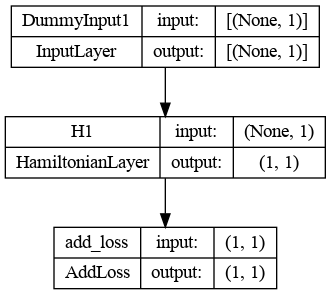

In [28]:
from keras.utils.vis_utils import plot_model
# save as pdf
plot_model(Ising1, to_file='TwoQubitIsing1_plot.pdf', show_shapes=True, show_layer_names=True)
# save and display as png
plot_model(Ising1, to_file='TwoQubitIsing1_plot.png', show_shapes=True, show_layer_names=True)

## Store the ground state before training

In [29]:
ground_state_0=tf.identity(HL.ground_state())
print(ground_state_0)

tf.Tensor(
[[-0.26+0.5j  -0.49+0.1j ]
 [-0.29+0.39j -0.29-0.32j]], shape=(2, 2), dtype=complex64)


## Store the weights before training

In [30]:
weight0=tf.identity(Ising1.weights)
print(weight0)

tf.Tensor([[0.94 0.14 0.03 0.77 0.74 0.72]], shape=(1, 6), dtype=float32)


# Train

We compile the model

In [31]:
Ising1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [32]:
history1 = Ising1.fit(x=np.zeros(10,),epochs=1000, verbose=0)

Check the weights after training

In [33]:
Ising1.weights

[<tf.Variable 'theta:0' shape=(6,) dtype=float32, numpy=
 array([ 1.03e-22,  1.21e-24, -4.84e-24,  7.41e-01,  4.94e-01,  6.46e-01],
       dtype=float32)>]

Plot the training history

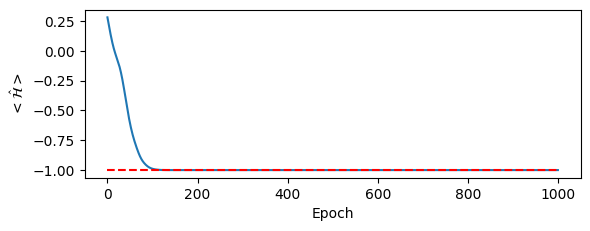

In [34]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history1.history['loss'])
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
# superimpose the lowest eigenvalue
xline=np.linspace(0,1000,100);
yline=-np.sqrt(1.0)*np.ones_like(xline);
plt.plot(xline,yline,'r--')
#print the training hystory on a file
plt. savefig("trainingTwoQuibtModelIsing1.pdf", format="pdf", bbox_inches="tight")

Final value for the mean Hamiltonian

In [35]:
print(history1.history['loss'][-1])

-1.0


Ground state computed from the feature map function with the trained weights and bias

In [36]:
phi=FeatureMapU1(Ising1.weights[0],HL1.bias)
print(phi)

tf.Tensor(
[[-3.05e-01+9.52e-01j  4.92e-24-7.67e-25j]
 [ 7.96e-23+6.57e-23j  0.00e+00+0.00e+00j]], shape=(2, 2), dtype=complex64)


Check if the ground state is normalized

In [37]:
quantummap.Scalar(phi,phi)

<tf.Tensor: shape=(1, 1), dtype=complex64, numpy=array([[1.+0.j]], dtype=complex64)>

Ground state from the Hamiltonian layer (must be the same as above)

In [38]:
print(HL1.ground_state())

tf.Tensor(
[[-3.05e-01+9.52e-01j  4.92e-24-7.67e-25j]
 [ 7.96e-23+6.57e-23j  0.00e+00+0.00e+00j]], shape=(2, 2), dtype=complex64)


Check the normalizzation

In [39]:
quantummap.Scalar(HL1.ground_state(),HL1.ground_state())

<tf.Tensor: shape=(1, 1), dtype=complex64, numpy=array([[1.+0.j]], dtype=complex64)>

Parameters theta

In [40]:
HL1.theta

<tf.Variable 'theta:0' shape=(6,) dtype=float32, numpy=
array([ 1.03e-22,  1.21e-24, -4.84e-24,  7.41e-01,  4.94e-01,  6.46e-01],
      dtype=float32)>

Parameters retrieved as weights (same as theta)

In [41]:
HL1.weights

[<tf.Variable 'theta:0' shape=(6,) dtype=float32, numpy=
 array([ 1.03e-22,  1.21e-24, -4.84e-24,  7.41e-01,  4.94e-01,  6.46e-01],
       dtype=float32)>]

Mean Hamiltonian after training

In [42]:
HL1(0)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.]], dtype=float32)>

### Entanglement entropy of ground state

In [43]:
quantummap.VonNeumannEntropy2(HL1.ground_state())

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 0.], dtype=float32)>)

## Define a new model with $h_0=h$ and $h_1=0$

In [44]:
# hyperparameter for the Hamiltonain
J=1.0
h=[1.0,0.0]
# Input layer (one dummy input)
xin2 = tf.keras.layers.Input(1);
# Hamiltonian layer
HL2=HamiltonianLayer(J=J,h=h, nparams=6,FeatureMap=FeatureMapU1, name='H2')
# output
meanH2=HL2(xin2)
# trainable model returning meanH
Ising2 = tf.keras.Model(inputs = xin2, outputs=meanH2, name='model2')
# add loss function
Ising2.add_loss(meanH2)

### Compile and train

Last value of loss -0.9999997019767761


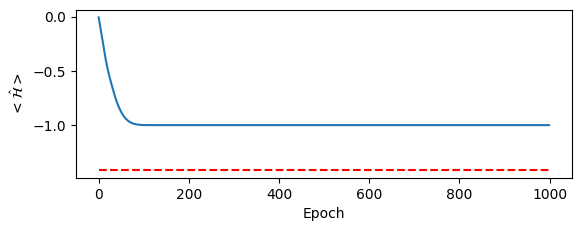

In [45]:
Ising2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
history2 = Ising2.fit(x=np.zeros(10,),epochs=1000, verbose=0)
# Plot training & validation accuracy values
f2 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history2.history['loss'])
xline=np.linspace(0,1000,100);
yline=-np.sqrt(2.0)*np.ones_like(xline);
plt.plot(xline,yline,'r--')
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
#print the training hystory on a file
plt. savefig("trainingTwoQuibtModelIsing2.pdf", format="pdf", bbox_inches="tight")
#print last value of Hamiltonian
print("Last value of loss "+repr(history2.history['loss'][-1]))

### Print ground state

In [46]:
print(HL2.ground_state())

tf.Tensor(
[[-0.49+0.09j  0.49-0.12j]
 [-0.49+0.09j  0.49-0.12j]], shape=(2, 2), dtype=complex64)


### Check the entropy of the ground state

In [47]:
quantummap.VonNeumannEntropy2(HL2.ground_state())

(<tf.Tensor: shape=(), dtype=float32, numpy=5.159494e-07>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.00e+00, 3.92e-14], dtype=float32)>)

### Compute eigenvalue of H for check

In [48]:
tf.linalg.eig(quantummap.Transform2Matrix(HL2.H))

(<tf.Tensor: shape=(4,), dtype=complex64, numpy=array([-1.41+0.j,  1.41+0.j,  1.41+0.j, -1.41+0.j], dtype=complex64)>,
 <tf.Tensor: shape=(4, 4), dtype=complex64, numpy=
 array([[-0.92+0.j,  0.38+0.j,  0.  +0.j,  0.  +0.j],
        [ 0.  +0.j,  0.  +0.j,  0.92+0.j,  0.38+0.j],
        [-0.38+0.j, -0.92+0.j,  0.  +0.j,  0.  +0.j],
        [ 0.  +0.j,  0.  +0.j, -0.38+0.j,  0.92+0.j]], dtype=complex64)>)

## Define and train a model with $h_0=h_1=h$

### model definition

In [49]:
# hyperparameter for the Hamiltonain
J=1.0
h=[1.0,1.0]
# Input layer (one dummy input)
xin3 = tf.keras.layers.Input(1);
# Hamiltonian layer
HL3=HamiltonianLayer(J=J,h=h, nparams=6,FeatureMap=FeatureMapU1, name='H3')
# output
meanH3=HL3(xin3)
# trainable model returning meanH
Ising3 = tf.keras.Model(inputs = xin3, outputs=meanH3, name='model3')
# add loss function
Ising3.add_loss(meanH3)

### eigenvalues

In [50]:
e3=tf.linalg.eig(quantummap.Transform2Matrix(HL3.H))
print(e3[0])
# find the lowest eigenvalue
e3min=np.min(tf.math.real(e3[0].numpy()))
print("Lowest eigenvalues "+repr(e3min))

tf.Tensor([ 1.  +0.j -1.  +0.j -2.24+0.j  2.24+0.j], shape=(4,), dtype=complex64)
Lowest eigenvalues -2.2360685


### Compile and train

Last value of loss -2.0


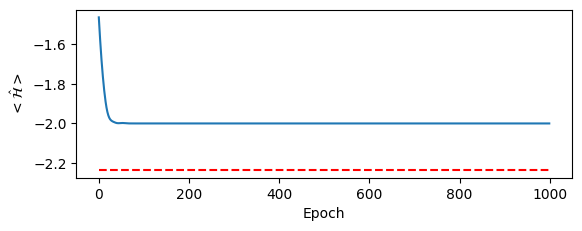

In [51]:
Ising3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
history3 = Ising3.fit(x=np.zeros(10,),epochs=1000, verbose=0)
# Plot training & validation accuracy values
f3 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history3.history['loss'])
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
xline=np.linspace(0,1000,100);
yline=e3min*np.ones_like(xline);
plt.plot(xline,yline,'r--')
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
#print the training hystory on a file
plt. savefig("trainingTwoQuibtModelIsing3.pdf", format="pdf", bbox_inches="tight")
#print last value of Hamiltonian
print("Last value of loss "+repr(history3.history['loss'][-1]))

### Ground state and its entropy

In [52]:
print(HL3.ground_state())

tf.Tensor(
[[-0.49+0.1j -0.49+0.1j]
 [-0.49+0.1j -0.49+0.1j]], shape=(2, 2), dtype=complex64)


In [53]:
quantummap.VonNeumannEntropy2(HL3.ground_state())

(<tf.Tensor: shape=(), dtype=float32, numpy=4.425682e-15>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.00e+00, 1.11e-16], dtype=float32)>)

### Eigenvalues

In [54]:
tf.linalg.eig(quantummap.Transform2Matrix(HL3.H))

(<tf.Tensor: shape=(4,), dtype=complex64, numpy=array([ 1.  +0.j, -1.  +0.j, -2.24+0.j,  2.24+0.j], dtype=complex64)>,
 <tf.Tensor: shape=(4, 4), dtype=complex64, numpy=
 array([[ 0.00e+00+0.j, -7.07e-01+0.j, -6.02e-01+0.j,  3.72e-01+0.j],
        [ 7.07e-01+0.j,  2.93e-08+0.j, -3.72e-01+0.j, -6.02e-01+0.j],
        [-7.07e-01+0.j,  4.05e-08+0.j, -3.72e-01+0.j, -6.02e-01+0.j],
        [ 0.00e+00+0.j,  7.07e-01+0.j, -6.02e-01+0.j,  3.72e-01+0.j]],
       dtype=complex64)>)

**Remark** in this case the model cannot find the low energy state, as this is entangled, and the feature map we are using does not have entanglement

Thus we have to consider a different feature map with entanglement

# Define an entangled feature map by a CZ gate

In [55]:
@tf.function
def FeatureMapU2(theta, psi):
    """ Feature Map for the 
    Variational Quantum Algorithm
    with entanglement
    Obtained by FeatureMapU1
    with an additional CZ gate
    
    Params
    ------
    theta, shape=(6,) real 
    psi,   two-qubit state
    
    Returns
    -------
    A two-qubit state
    """
    phi=FeatureMapU1(theta,psi)
    # add an CZ gate that generates entanglement
    phi=quantummap.Gate(quantummap.CZ,phi)
    return phi

### Test the FeatureMapU2 with random weights

In [56]:
# generate random weights
theta_test=np.random.random(6)
print("Weights theta_test "+repr(theta_test))
# generate a state with bias q00
phi_test=FeatureMapU2(theta_test,quantummap.q00)
print(phi_test)

Weights theta_test array([0.28, 0.59, 0.67, 0.06, 0.95, 0.88])
tf.Tensor(
[[-0.5 +0.33j  0.35+0.42j]
 [-0.43-0.03j -0.12+0.37j]], shape=(2, 2), dtype=complex64)


### Check if the new state is entangled

In [57]:
print("Entropy "+repr(quantummap.VonNeumannEntropy2(phi_test)[0]))
print("Probabilities "+repr(quantummap.VonNeumannEntropy2(phi_test)[1]))

Entropy <tf.Tensor: shape=(), dtype=float32, numpy=0.06107338>
Probabilities <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.99, 0.01], dtype=float32)>


<code>quantumap.VonNeumannEntropy2</code> return a list of two elements
entropy is the element [0]
the second output [1] are the probabilities in the density matrix

## Define the model with the new feature map

In [58]:
# hyperparameter for the Hamiltonain
J=1.0
h=[1.0,1.0]
# Input layer (one dummy input)
xin4 = tf.keras.layers.Input(1);
# Hamiltonian layer
HL4=HamiltonianLayer(J=J,h=h, nparams=6,FeatureMap=FeatureMapU2, name='H4')
# output
meanH4=HL4(xin4)
# trainable model returning meanH
Ising4 = tf.keras.Model(inputs = xin4, outputs=meanH4, name='model4')
# add loss function
Ising4.add_loss(meanH4)

Last value of loss -1.9999969005584717


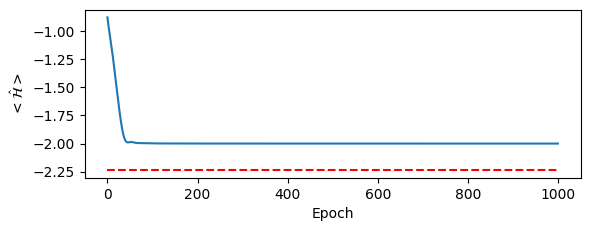

In [59]:
Ising4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
history4 = Ising4.fit(x=np.zeros(10,),epochs=1000, verbose=0)
# Plot training & validation accuracy values
f4 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history4.history['loss'])
xline=np.linspace(0,1000,100);
yline=e3min*np.ones_like(xline);
plt.plot(xline,yline,'r--')
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
#print the training hystory on a file
plt. savefig("trainingTwoQuibtModelIsing4.pdf", format="pdf", bbox_inches="tight")
#print last value of Hamiltonian
print("Last value of loss "+repr(history4.history['loss'][-1]))

In [60]:
quantummap.VonNeumannEntropy2(HL4.ground_state())

(<tf.Tensor: shape=(), dtype=float32, numpy=1.7198461e-07>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.00e+00, 4.96e-14], dtype=float32)>)

## Define a model with iterated entangled feature map

In [61]:
@tf.function
def FeatureMapU3(theta, psi):
    # Define a new feature map 
    # with entanglement
    # by iterating the FeatureMapU2
    psi = FeatureMapU2(theta, psi)
    psi = FeatureMapU2(theta, psi)
    return psi

### Test the iterated map 

In [62]:
# generate a state with bias q00
phi_test2=FeatureMapU3(theta_test,quantummap.q00)
print(phi_test2)
print("Entropy "+repr(quantummap.VonNeumannEntropy2(phi_test2)))

tf.Tensor(
[[ 0.08-0.68j -0.09-0.54j]
 [-0.26-0.27j -0.08-0.28j]], shape=(2, 2), dtype=complex64)
Entropy (<tf.Tensor: shape=(), dtype=float32, numpy=0.16485608>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.98, 0.02], dtype=float32)>)


**Remark** the iterated feature map as higher entropy

In [63]:
print(theta_test)

[0.28 0.59 0.67 0.06 0.95 0.88]


## Define the model with the new feature map

In [64]:
# hyperparameter for the Hamiltonain
J=1.0
h=[1.0,1.0]
# Input layer (one dummy input)
xin5 = tf.keras.layers.Input(1);
# Hamiltonian layer
HL5=HamiltonianLayer(J=J,h=h, nparams=6,FeatureMap=FeatureMapU3, name='H5')
# output
meanH5=HL5(xin5)
# trainable model returning meanH
Ising5 = tf.keras.Model(inputs = xin5, outputs=meanH5, name='model5')
# add loss function
Ising5.add_loss(meanH5)

Last value of loss -2.236067771911621


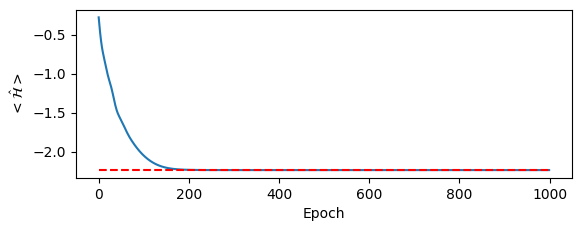

In [65]:
# initialize tqdm callback with default parameters
Ising5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
history5 = Ising5.fit(x=np.zeros(10,),epochs=1000, verbose=0)
# Plot training & validation accuracy values
f5 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history5.history['loss'])
xline=np.linspace(0,1000,100);
yline=e3min*np.ones_like(xline);
plt.plot(xline,yline,'r--')
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
#print the training hystory on a file
plt. savefig("trainingTwoQuibtModelIsing5.pdf", format="pdf", bbox_inches="tight")
#print last value of Hamiltonian
print("Last value of loss "+repr(history5.history['loss'][-1]))

In [66]:
quantummap.VonNeumannEntropy2(HL5.ground_state())

(<tf.Tensor: shape=(), dtype=float32, numpy=0.29811865>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.95, 0.05], dtype=float32)>)